# Power Market Price Time Series

## Import (Library and Data) 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose


from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR

In [ ]:
# Load the dataset
df = pd.read_csv("")
# df = pd.DataFrame(df)

df.info()
df.describe()

df.shape
df.columns
df.index
df.dtypes

df.head()
df.tail()

FileNotFoundError: [Errno 2] No such file or directory: 'data/power_prices.csv'

## Data Conversion and Cleaning

In [ ]:
## time stamp
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True) # index

# Resample hourly to daily for smoother trends (if required)
df_daily = df['price'].resample('D').mean()

In [ ]:
## missing data
df.isnull().sum()

df['price'].fillna(df['price'].mean(), inplace=True)
df['price'].fillna(method='ffill', inplace=True)

In [ ]:
## duplicate

duplicates

## EDA

In [ ]:
df['price'].plot(figsize=(14, 7), title = 'Power Market Price')
plt.show()

df['price'].rolling(window = 24 * 7).mean().plot(label = '7-day rolling mean', figsize=(14, 7), title = 'Power Market Price')
df['price'].rolling(window = 24 * 7).std().plot(label = '7-day rolling std', figsize=(14, 7), title = 'Power Market Price')
plt.legend()
plt.show()


## Time series 

In [ ]:
result = seasonal_decompose(df['price'], model='additive', period=24)
result.plot()
plt.show()

## Feature Engineering

In [ ]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['is_weekend'] = df['dayofweek'] >= 5

df['price_lag1'] = df['price'].shift(1)
df['price_lag24'] = df['price'].shift(24)

df[['price', 'price_lag1', 'price_lag24']].corr()


# CAISO Analysis

## Data Preparation

### CAISO LMP 

In [112]:
import gridstatus
import plotly.express as px

# iso = gridstatus.CAISO()

# df = iso.get_as_prices(date="Oct 15, 2022")
# df

In [113]:
caiso = gridstatus.CAISO()

start = pd.Timestamp("April 20, 2025").normalize()
end = pd.Timestamp.now().normalize()

locations = ["TH_NP15_GEN-APND", "TH_SP15_GEN-APND", "TH_ZP26_GEN-APND"]

lmp_df = caiso.get_lmp(
    start=start, end=end, market="DAY_AHEAD_HOURLY", locations=locations, sleep=5
)
lmp_df.head()


2025-05-03 21:49:05 - DEBUG - Dataset config: {'query': {'path': 'SingleZip', 'resultformat': 6, 'queryname': 'PRC_LMP', 'version': 12}, 'params': {'market_run_id': 'DAM', 'node': None, 'grp_type': [None, 'ALL', 'ALL_APNODES']}}
2025-05-03 21:49:05 - INFO - Fetching URL: http://oasis.caiso.com/oasisapi/SingleZip?resultformat=6&queryname=PRC_LMP&version=12&market_run_id=DAM&node=TH_NP15_GEN-APND,TH_SP15_GEN-APND,TH_ZP26_GEN-APND&startdatetime=20250420T07:00-0000&enddatetime=20250503T07:00-0000
2025-05-03 21:49:07 - DEBUG - Found 1 files: ['20250420_20250503_PRC_LMP_DAM_20250503_18_49_06_v12.csv']
2025-05-03 21:49:07 - DEBUG - Parsing file: 20250420_20250503_PRC_LMP_DAM_20250503_18_49_06_v12.csv


,Time,Interval Start,Interval End,Market,Location,Location Type,LMP,Energy,Congestion,Loss
0,2025-04-20 00:00:00-07:00,2025-04-20 00:00:00-07:00,2025-04-20 01:00:00-07:00,DAY_AHEAD_HOURLY,TH_NP15_GEN-APND,Trading Hub,28.77610,33.30717,-3.16547,-1.36559
1,2025-04-20 00:00:00-07:00,2025-04-20 00:00:00-07:00,2025-04-20 01:00:00-07:00,DAY_AHEAD_HOURLY,TH_SP15_GEN-APND,Trading Hub,31.58829,33.30717,-0.41657,-1.30231
2,2025-04-20 00:00:00-07:00,2025-04-20 00:00:00-07:00,2025-04-20 01:00:00-07:00,DAY_AHEAD_HOURLY,TH_ZP26_GEN-APND,Trading Hub,32.59772,33.30717,0.00000,-0.70944
3,2025-04-20 01:00:00-07:00,2025-04-20 01:00:00-07:00,2025-04-20 02:00:00-07:00,DAY_AHEAD_HOURLY,TH_NP15_GEN-APND,Trading Hub,27.51442,32.05128,-3.20993,-1.32692
4,2025-04-20 01:00:00-07:00,2025-04-20 01:00:00-07:00,2025-04-20 02:00:00-07:00,DAY_AHEAD_HOURLY,TH_SP15_GEN-APND,Trading Hub,30.40209,32.05128,-0.41842,-1.23077


In [114]:
negative_lmps = lmp_df[lmp_df["LMP"] < 0].set_index("Time")
negative_per_day = (
    negative_lmps.groupby("Location").resample("D")["LMP"].count().reset_index()
)

fig = px.bar(
    negative_per_day,
    x="Time",
    y="LMP",
    title="Negative LMPs per Month - CAISO",
    color="Location",
)

fig.update_yaxes(title="Number of Negative LMPs")
fig.show()

In [115]:
lmp_df['Time'] = pd.to_datetime(lmp_df['Time'], format='%Y-%m-%d %H:%M:%S')
lmp_df.set_index('Time', inplace=True)
lmp_df.head()

,Interval Start,Interval End,Market,Location,Location Type,LMP,Energy,Congestion,Loss
Time,,,,,,,,,
2025-04-20 00:00:00-07:00,2025-04-20 00:00:00-07:00,2025-04-20 01:00:00-07:00,DAY_AHEAD_HOURLY,TH_NP15_GEN-APND,Trading Hub,28.77610,33.30717,-3.16547,-1.36559
2025-04-20 00:00:00-07:00,2025-04-20 00:00:00-07:00,2025-04-20 01:00:00-07:00,DAY_AHEAD_HOURLY,TH_SP15_GEN-APND,Trading Hub,31.58829,33.30717,-0.41657,-1.30231
2025-04-20 00:00:00-07:00,2025-04-20 00:00:00-07:00,2025-04-20 01:00:00-07:00,DAY_AHEAD_HOURLY,TH_ZP26_GEN-APND,Trading Hub,32.59772,33.30717,0.00000,-0.70944
2025-04-20 01:00:00-07:00,2025-04-20 01:00:00-07:00,2025-04-20 02:00:00-07:00,DAY_AHEAD_HOURLY,TH_NP15_GEN-APND,Trading Hub,27.51442,32.05128,-3.20993,-1.32692
2025-04-20 01:00:00-07:00,2025-04-20 01:00:00-07:00,2025-04-20 02:00:00-07:00,DAY_AHEAD_HOURLY,TH_SP15_GEN-APND,Trading Hub,30.40209,32.05128,-0.41842,-1.23077


### CAISO Mix

In [116]:
mix_df = caiso.get_fuel_mix(start, end=end, verbose=False)
mix_df.head()

100%|██████████| 13/13 [00:04<00:00,  2.86it/s]


,Time,Interval Start,Interval End,Solar,Wind,Geothermal,Biomass,Biogas,Small Hydro,Coal,Nuclear,Natural Gas,Large Hydro,Batteries,Imports,Other
0,2025-04-20 00:00:00-07:00,2025-04-20 00:00:00-07:00,2025-04-20 00:05:00-07:00,6,3289,818,187,111,262,0,1134,2898,3585,1412,6896,0
1,2025-04-20 00:05:00-07:00,2025-04-20 00:05:00-07:00,2025-04-20 00:10:00-07:00,7,3244,832,189,112,261,0,1134,2976,3508,2012,6520,0
2,2025-04-20 00:10:00-07:00,2025-04-20 00:10:00-07:00,2025-04-20 00:15:00-07:00,6,3224,811,185,111,260,0,1134,3083,3519,2203,6379,0
3,2025-04-20 00:15:00-07:00,2025-04-20 00:15:00-07:00,2025-04-20 00:20:00-07:00,7,3150,833,178,111,260,0,1134,3094,3479,2202,6406,0
4,2025-04-20 00:20:00-07:00,2025-04-20 00:20:00-07:00,2025-04-20 00:25:00-07:00,7,3069,837,178,112,259,0,1134,3085,3521,2169,6445,0


In [117]:
hourly_mix = mix_df.set_index("Time").resample("H").mean()

daily_mix = (
    hourly_mix
    .select_dtypes(include='number')
    .resample("D").sum()
    .reset_index()
    .iloc[1:-1]
)

top_sources = daily_mix.drop(columns=["Time"]).sum().sort_values(ascending=False).index.tolist()
fig = px.bar(daily_mix, x="Time", y=top_sources, title="Fuel Mix by Day - CAISO")
fig.show()

/var/folders/4y/y61rk3957l34yct000xkq_5r0000gn/T/ipykernel_70874/4107069227.py:1: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



In [118]:
mix_df.set_index('Time', inplace=True)

# Only resample numeric columns
mix_df_numeric = mix_df.select_dtypes(include='number')

mix_df_hourly = (
    mix_df_numeric
    .resample('H')
    .sum()
    .reset_index()
)

mix_df_hourly.head()

/var/folders/4y/y61rk3957l34yct000xkq_5r0000gn/T/ipykernel_70874/3042311120.py:8: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



,Time,Solar,Wind,Geothermal,Biomass,Biogas,Small Hydro,Coal,Nuclear,Natural Gas,Large Hydro,Batteries,Imports,Other
0,2025-04-20 00:00:00-07:00,82,37124,9960,2171,1337,3108,0,13608,36934,42041,22489,79391,0
1,2025-04-20 01:00:00-07:00,90,39033,9888,2167,1338,3101,0,13607,37760,41828,9940,88761,0
2,2025-04-20 02:00:00-07:00,75,40901,9838,2173,1344,3090,0,13617,34683,41499,-1974,94422,0
3,2025-04-20 03:00:00-07:00,84,40338,9841,2171,1344,3112,0,13615,34842,40586,-3546,93502,0
4,2025-04-20 04:00:00-07:00,72,36695,9943,2187,1337,3111,0,13611,35635,37552,3950,89650,0


### CAISO Load

In [119]:
load_df = caiso.get_load(start, end=end)
load_df.head()

100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


,Time,Interval Start,Interval End,Load
0,2025-04-20 00:00:00-07:00,2025-04-20 00:00:00-07:00,2025-04-20 00:05:00-07:00,20622
1,2025-04-20 00:05:00-07:00,2025-04-20 00:05:00-07:00,2025-04-20 00:10:00-07:00,20948
2,2025-04-20 00:10:00-07:00,2025-04-20 00:10:00-07:00,2025-04-20 00:15:00-07:00,21102
3,2025-04-20 00:15:00-07:00,2025-04-20 00:15:00-07:00,2025-04-20 00:20:00-07:00,21060
4,2025-04-20 00:20:00-07:00,2025-04-20 00:20:00-07:00,2025-04-20 00:25:00-07:00,21119


In [120]:
hourly_load = load_df.set_index("Time").resample("H").mean()
daily_load = (
    hourly_load
    .select_dtypes(include='number')
    .resample("D").sum()
    .reset_index()
    .iloc[1:-1]
)

fig = px.line(daily_load, x="Time", y="Load", title="Daily Load - CAISO")
fig.show()

/var/folders/4y/y61rk3957l34yct000xkq_5r0000gn/T/ipykernel_70874/3672753960.py:1: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



In [121]:
load_df.set_index('Time', inplace=True)

# Only resample numeric columns
load_df_numeric = load_df.select_dtypes(include='number')

load_df_hourly = (
    load_df_numeric
    .resample('H')
    .sum()
    .reset_index()
)

load_df_hourly.head()

/var/folders/4y/y61rk3957l34yct000xkq_5r0000gn/T/ipykernel_70874/1320051042.py:8: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



,Time,Load
0,2025-04-20 00:00:00-07:00,250765
1,2025-04-20 01:00:00-07:00,245563
2,2025-04-20 02:00:00-07:00,234821
3,2025-04-20 03:00:00-07:00,230905
4,2025-04-20 04:00:00-07:00,229339


In [122]:
merge_df = pd.merge(lmp_df, mix_df_hourly, on='Time', how='inner')
merged_df = pd.merge(merge_df, load_df_hourly, on='Time', how='left')
merged_df.head()


,Time,Interval Start,Interval End,Market,Location,Location Type,LMP,Energy,Congestion,Loss,...,Biogas,Small Hydro,Coal,Nuclear,Natural Gas,Large Hydro,Batteries,Imports,Other,Load
0,2025-04-20 00:00:00-07:00,2025-04-20 00:00:00-07:00,2025-04-20 01:00:00-07:00,DAY_AHEAD_HOURLY,TH_NP15_GEN-APND,Trading Hub,28.77610,33.30717,-3.16547,-1.36559,...,1337,3108,0,13608,36934,42041,22489,79391,0,250765
1,2025-04-20 00:00:00-07:00,2025-04-20 00:00:00-07:00,2025-04-20 01:00:00-07:00,DAY_AHEAD_HOURLY,TH_SP15_GEN-APND,Trading Hub,31.58829,33.30717,-0.41657,-1.30231,...,1337,3108,0,13608,36934,42041,22489,79391,0,250765
2,2025-04-20 00:00:00-07:00,2025-04-20 00:00:00-07:00,2025-04-20 01:00:00-07:00,DAY_AHEAD_HOURLY,TH_ZP26_GEN-APND,Trading Hub,32.59772,33.30717,0.00000,-0.70944,...,1337,3108,0,13608,36934,42041,22489,79391,0,250765
3,2025-04-20 01:00:00-07:00,2025-04-20 01:00:00-07:00,2025-04-20 02:00:00-07:00,DAY_AHEAD_HOURLY,TH_NP15_GEN-APND,Trading Hub,27.51442,32.05128,-3.20993,-1.32692,...,1338,3101,0,13607,37760,41828,9940,88761,0,245563
4,2025-04-20 01:00:00-07:00,2025-04-20 01:00:00-07:00,2025-04-20 02:00:00-07:00,DAY_AHEAD_HOURLY,TH_SP15_GEN-APND,Trading Hub,30.40209,32.05128,-0.41842,-1.23077,...,1338,3101,0,13607,37760,41828,9940,88761,0,245563


In [123]:
merged_df.drop(columns = ['Interval Start', 'Interval End'], inplace=True)
merged_df.head()

,Time,Market,Location,Location Type,LMP,Energy,Congestion,Loss,Solar,Wind,...,Biogas,Small Hydro,Coal,Nuclear,Natural Gas,Large Hydro,Batteries,Imports,Other,Load
0,2025-04-20 00:00:00-07:00,DAY_AHEAD_HOURLY,TH_NP15_GEN-APND,Trading Hub,28.77610,33.30717,-3.16547,-1.36559,82,37124,...,1337,3108,0,13608,36934,42041,22489,79391,0,250765
1,2025-04-20 00:00:00-07:00,DAY_AHEAD_HOURLY,TH_SP15_GEN-APND,Trading Hub,31.58829,33.30717,-0.41657,-1.30231,82,37124,...,1337,3108,0,13608,36934,42041,22489,79391,0,250765
2,2025-04-20 00:00:00-07:00,DAY_AHEAD_HOURLY,TH_ZP26_GEN-APND,Trading Hub,32.59772,33.30717,0.00000,-0.70944,82,37124,...,1337,3108,0,13608,36934,42041,22489,79391,0,250765
3,2025-04-20 01:00:00-07:00,DAY_AHEAD_HOURLY,TH_NP15_GEN-APND,Trading Hub,27.51442,32.05128,-3.20993,-1.32692,90,39033,...,1338,3101,0,13607,37760,41828,9940,88761,0,245563
4,2025-04-20 01:00:00-07:00,DAY_AHEAD_HOURLY,TH_SP15_GEN-APND,Trading Hub,30.40209,32.05128,-0.41842,-1.23077,90,39033,...,1338,3101,0,13607,37760,41828,9940,88761,0,245563


## EDA

In [124]:
plt.figure(figsize=(12, 6))

fig = px.line(
    merged_df,
    x='Time',
    y='LMP',
    color='Location',
    title='LMP Over Time by Location',
    labels={'LMP': 'LMP ($/MWh)', 'Time': 'Timestamp'},
)

fig.show()

# # Group by Location and plot each group's LMP over time
# for location, group in merged_df.groupby('Location'):
#     plt.plot(group.index, group['LMP'], label=location)

# plt.title('LMP Over Time by Location')
# plt.xlabel('Time')
# plt.ylabel('LMP ($/MWh)')
# plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.grid(True)
# plt.show()

<Figure size 1200x600 with 0 Axes>

In [125]:
df_NP15 = merged_df[merged_df['Location'] == 'TH_NP15_GEN-APND']
df_NP15.head()

,Time,Market,Location,Location Type,LMP,Energy,Congestion,Loss,Solar,Wind,...,Biogas,Small Hydro,Coal,Nuclear,Natural Gas,Large Hydro,Batteries,Imports,Other,Load
0,2025-04-20 00:00:00-07:00,DAY_AHEAD_HOURLY,TH_NP15_GEN-APND,Trading Hub,28.77610,33.30717,-3.16547,-1.36559,82,37124,...,1337,3108,0,13608,36934,42041,22489,79391,0,250765
3,2025-04-20 01:00:00-07:00,DAY_AHEAD_HOURLY,TH_NP15_GEN-APND,Trading Hub,27.51442,32.05128,-3.20993,-1.32692,90,39033,...,1338,3101,0,13607,37760,41828,9940,88761,0,245563
6,2025-04-20 02:00:00-07:00,DAY_AHEAD_HOURLY,TH_NP15_GEN-APND,Trading Hub,27.88758,30.77237,-1.76774,-1.11704,75,40901,...,1344,3090,0,13617,34683,41499,-1974,94422,0,234821
9,2025-04-20 03:00:00-07:00,DAY_AHEAD_HOURLY,TH_NP15_GEN-APND,Trading Hub,27.41910,30.26596,-1.75123,-1.09563,84,40338,...,1344,3112,0,13615,34842,40586,-3546,93502,0,230905
12,2025-04-20 04:00:00-07:00,DAY_AHEAD_HOURLY,TH_NP15_GEN-APND,Trading Hub,27.75521,30.89886,-2.03747,-1.10618,72,36695,...,1337,3111,0,13611,35635,37552,3950,89650,0,229339


In [126]:
df_NP15.columns

Index(['Time', 'Market', 'Location', 'Location Type', 'LMP', 'Energy',
       'Congestion', 'Loss', 'Solar', 'Wind', 'Geothermal', 'Biomass',
       'Biogas', 'Small Hydro', 'Coal', 'Nuclear', 'Natural Gas',
       'Large Hydro', 'Batteries', 'Imports', 'Other', 'Load'],
      dtype='object')

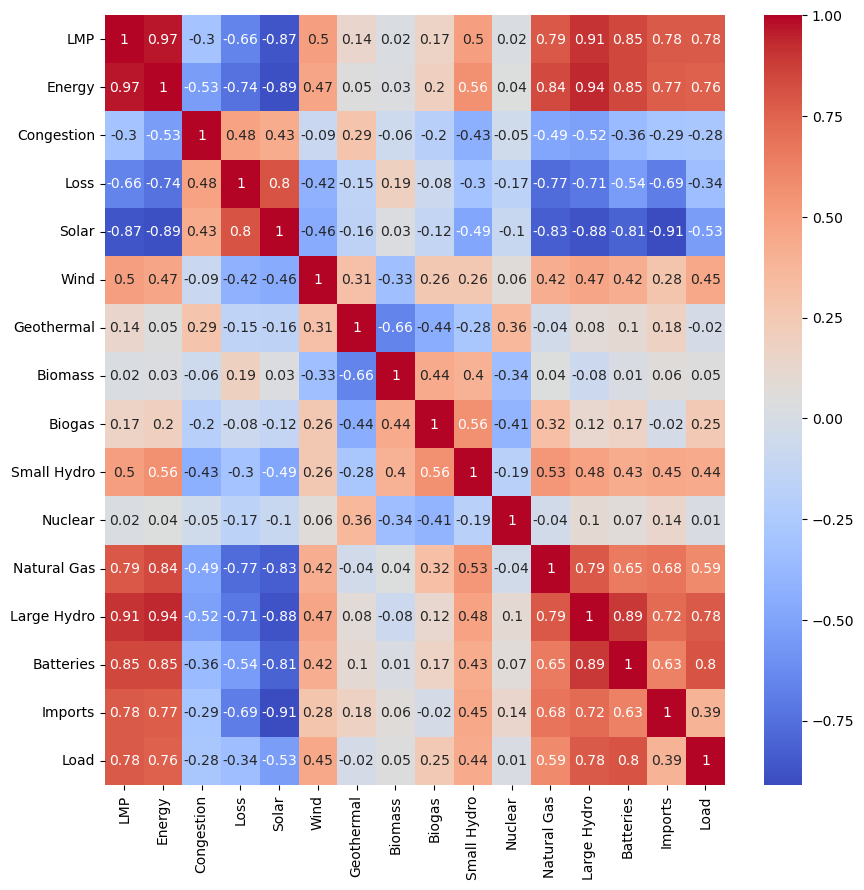

In [127]:
num_df_NP15 = df_NP15.select_dtypes(include=['number']).drop(columns=['Coal', 'Other'])

plt.figure(figsize=(10,10))
sns.heatmap(num_df_NP15.corr().round(2), cmap = 'coolwarm', annot=True)
plt.show()


In [ ]:
# sns.jointplot(x='LMP', y='Energy', data=df_NP15, kind='scatter')

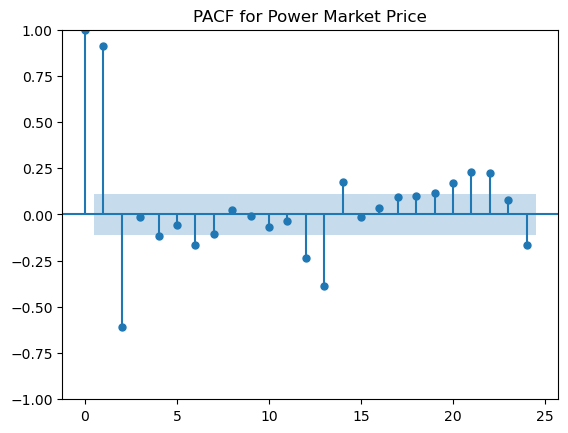

In [ ]:
# ### seasonal decomposition
# result = seasonal_decompose(df_NP15['LMP'], model='additive', period=24)
# result.plot()
# plt.show()

### acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# plot_acf(df_NP15["LMP"],lags=24,title="ACF for Power Market Price")
# plt.show()

# plot_pacf(df_NP15["LMP"],lags=24,title="PACF for Power Market Price")
# plt.show()

### rolling mean and std
# df_NP15['LMP'].plot(figsize=(14, 7), title = 'Power Market Price')
# plt.show()

# df_NP15['LMP'].rolling(window = 7).mean().plot(label = '7-day rolling mean', figsize=(14, 7), title = 'Power Market Price')
# df_NP15['LMP'].rolling(window = 7).std().plot(label = '7-day rolling std', figsize=(14, 7), title = 'Power Market Price')
# plt.legend()
# plt.show()

## Time Series

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from pmdarima import auto_arima

# not a random walk
adf = adfuller(df_NP15["LMP"])
print("p-value of LMP: {}".format(float(adf[1])))

p-value of LMP: 1.1173150402402897e-12


### ARIMA

In [152]:
model = auto_arima(
    df_NP15["LMP"],
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    trace=True  # optional: shows testing of various models
)

print("Optimal order:", model.order)

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/SI/lib/python3.12/si

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1995.678, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2990.652, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2112.109, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2621.119, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1999.167, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1993.709, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2010.029, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1994.987, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1995.528, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1993.814, Time=0.02 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1997.453, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1961.133, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1995.083, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1959.171, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/SI/lib/python3.12/si

 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1962.445, Time=0.09 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.520 seconds
Optimal order: (2, 0, 0)


### GARCH

In [153]:
best_aic = float('inf')
best_model = None
best_order = None

for p in range(1, 4):        # You can extend to (5,5) but keep it small for speed
    for q in range(1, 4):
        try:
            model = arch_model(df_NP15['LMP'], vol='GARCH', p=p, q=q, dist='normal')
            res = model.fit(disp='off')
            if res.aic < best_aic:
                best_aic = res.aic
                best_model = res
                best_order = (p, q)
        except:
            continue

print(f'Best GARCH Order: {best_order}, AIC: {best_aic}')

Best GARCH Order: (1, 1), AIC: 2431.8088024699555


In [159]:
from statsmodels.tsa.api import VAR

df_var = df_NP15[['LMP', 'Energy', 'Congestion', 'Loss']].dropna()

model = VAR(df_var)  # use df_var if already stationary

# Find optimal lag with AIC/BIC
lag_selection = model.select_order(15)
print(lag_selection.summary())

optimal_lag = lag_selection.aic  # or bic
results = model.fit(optimal_lag)


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -16.73      -16.68   5.405e-08      -16.71
1       -20.37      -20.12   1.426e-09      -20.27
2       -20.93     -20.48*   8.158e-10     -20.75*
3       -20.90      -20.26   8.365e-10      -20.64
4       -20.85      -20.00   8.855e-10      -20.51
5       -20.88      -19.83   8.581e-10      -20.46
6       -20.94      -19.70   8.038e-10      -20.45
7       -20.93      -19.49   8.160e-10      -20.35
8       -21.05      -19.41   7.263e-10      -20.39
9       -21.19      -19.35   6.313e-10      -20.45
10      -21.28      -19.24   5.768e-10      -20.46
11      -21.26      -19.02   5.882e-10      -20.37
12      -21.23      -18.79   6.108e-10      -20.25
13      -21.35      -18.71   5.432e-10      -20.29
14      -21.62      -18.79   4.155e-10      -20.49
15     -21.63*      -18.59  4.148e-10*      -20.41
-------------------------------

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.



### SARIMAX

In [ ]:
stepwise_fit = auto_arima(
    df_NP15['LMP'],
    seasonal=True,
    m=1,  # hourly data
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(stepwise_fit.summary())

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/SI/lib/python3.12/si

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1946.705, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2655.487, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2102.794, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2323.717, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2990.652, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1979.869, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1961.133, Time=0.06 sec


/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1947.453, Time=0.21 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1947.528, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1995.083, Time=0.03 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1970.125, Time=0.06 sec


/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1962.445, Time=0.13 sec


/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=1942.383, Time=0.24 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=1938.938, Time=0.29 sec


/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=1945.737, Time=0.23 sec


/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=1940.141, Time=0.30 sec
 ARIMA(4,0,4)(0,0,0)[0] intercept   : AIC=1939.761, Time=0.32 sec


/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=1943.256, Time=0.40 sec


/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=1937.285, Time=0.31 sec


/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=1948.801, Time=0.26 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=1947.042, Time=0.20 sec


/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,2)(0,0,0)[0]             : AIC=1968.132, Time=0.28 sec

Best model:  ARIMA(5,0,2)(0,0,0)[0] intercept
Total fit time: 3.607 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  312
Model:               SARIMAX(5, 0, 2)   Log Likelihood                -959.642
Date:                Sat, 03 May 2025   AIC                           1937.285
Time:                        22:20:37   BIC                           1970.972
Sample:                             0   HQIC                          1950.749
                                - 312                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.0989      1.874      4.855      0.000       5.425 

<Axes: >

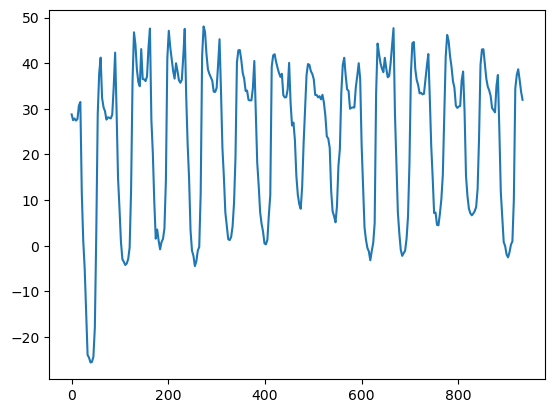

In [169]:
df_NP15['LMP'].plot()

### LSTM

In [172]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [174]:
# Normalize LMP
scaler = MinMaxScaler()
lmp_scaled = scaler.fit_transform(df_NP15['LMP'].values.reshape(-1, 1))

def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

n_steps = 24  # e.g., last 24 hours
X, y = create_sequences(lmp_scaled, n_steps)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Train/test split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

In [175]:
class LMP_LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(LMP_LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # take last output
        return out


In [182]:
model = LMP_LSTM()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 20
for epoch in range(n_epochs):
    model.train()
    for xb, yb in train_loader:
        out = model(xb)
        loss = loss_fn(out, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}")

Epoch 5/20, Loss: 0.0700
Epoch 10/20, Loss: 0.0396
Epoch 15/20, Loss: 0.0164
Epoch 20/20, Loss: 0.0299


In [183]:
model.eval()
with torch.no_grad():
    pred = model(X_test).numpy()
    actual = y_test.numpy()

    pred_inv = scaler.inverse_transform(pred)
    actual_inv = scaler.inverse_transform(actual.reshape(-1, 1))


# Build DataFrame
df_plot = pd.DataFrame({
    'Actual': actual_inv.flatten(),
    'Predicted': pred_inv.flatten(),
    'Index': range(len(actual_inv))
})

# Melt for plotting multiple lines
df_melt = df_plot.melt(id_vars='Index', value_vars=['Actual', 'Predicted'], 
                       var_name='Type', value_name='LMP')

# Plot
fig = px.line(df_melt, x='Index', y='LMP', color='Type', 
              title="LMP Forecast with PyTorch LSTM")

fig.show()

## Regression

In [165]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from lightgbm import LGBMRegressor

In [167]:
# split the train and test set and preprocess, apply the classifier
X_train, X_test, y_train, y_test = train_test_split(
    df_NP15.drop(['Time', 'Market', 'Location', 'LMP', 'Coal', 'Other'], axis=1), 
    df_NP15['LMP'], 
    test_size=0.2, 
    random_state=42)  

num_pipeline = Pipeline([
    ('impute',SimpleImputer(strategy='median')), # median
    ('scale',StandardScaler()),
    ('pca', PCA(n_components=5))
    ])


preprocessing_pipeline = ColumnTransformer([
    ('num', num_pipeline, ['Solar', 'Wind', 'Geothermal', 'Biomass',
       'Biogas', 'Small Hydro', 'Nuclear', 'Natural Gas',
       'Large Hydro', 'Batteries', 'Imports', 'Load'])
    ])

X_train_prepared = preprocessing_pipeline.fit_transform(X_train)
X_test_prepared = preprocessing_pipeline.transform(X_test)

regressors = {                         
    "MLP regressor": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42), 
    "KNN regressor": KNeighborsRegressor(n_neighbors=5),                                         
    "SVR(linear)": SVR(kernel='linear', C=0.025),                                                          
    "Decision Tree": DecisionTreeRegressor(random_state=42),                                           
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),         
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42), 
    "LightGBM": LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42),                                                                                            
}

# Train and evaluate each classifier
for name, clf in regressors.items():
    clf.fit(X_train_prepared, y_train)
    score = clf.score(X_test_prepared, y_test)
    print(f"{name}: {score:.2%} accuracy")

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.



MLP regressor: 95.34% accuracy
KNN regressor: 93.51% accuracy
SVR(linear): 91.78% accuracy
Decision Tree: 91.19% accuracy
Random Forest: 94.81% accuracy
AdaBoost: 92.90% accuracy
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 421
[LightGBM] [Info] Number of data points in the train set: 249, number of used features: 5
[LightGBM] [Info] Start training from score 23.496650
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/opt/anaconda3/envs/SI/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

